In [1]:
import os
import cv2
import json
import time
import numpy as np
import pandas as pd
from datetime import datetime

from utils.video_utils import read_video, save_video
from utils.bbox_utils import get_center_of_bbox
from trackers import BallTracker
from court_line_detector import CourtLineDetector

from functools import lru_cache

In [4]:
# ─── Config ───────────────────────────────────────────────────────────────
input_video_path = "input_videos/testmatch_short.mp4"
override_fps = None
sample_rate_sec = 1.0
min_segment_duration_s = 2.0

# ─── Start total timer ────────────────────────────────────────────────────
t_start_total = time.time()
ts = datetime.now().strftime("%Y%m%d_%H%M%S")

# ─── 1) Load video & FPS ─────────────────────────────────────────────────
t0 = time.time()
print("[1/8] Loading video and reading FPS…")
video_frames, fps, width, height, resolution = read_video(
    input_video_path, override_fps
)

n_frames = len(video_frames)
cap = cv2.VideoCapture(input_video_path)
native_fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
cap.release()
fps = override_fps if override_fps else native_fps
video_length_sec = n_frames / fps
print(
    f"[1/8] Loaded {n_frames} frames at {fps:.2f} fps "
    f"(native {native_fps:.2f}), length {video_length_sec:.1f}s"
)
runtimes = {"load_video": time.time() - t0}

# ─── 2) Coarse sampling for court presence ────────────────────────────────
t0 = time.time()
print("[2/8] Sampling for court presence…")
court_model = CourtLineDetector("models/keypoints_model.pth")
sample_step = max(1, int(fps * sample_rate_sec))
sample_idxs = list(range(0, n_frames, sample_step))
sample_flags = []
for idx in sample_idxs:
    flag = court_model.is_court_frame(video_frames[idx])
    sample_flags.append(flag)
print(f"[2/8] Completed {len(sample_idxs)} samples")
runtimes["sampling"] = time.time() - t0

# ─── 3) Collapse samples into coarse segments ───────────────────────────
t0 = time.time()
print("[3/8] Collapsing samples into coarse segments…")

coarse_segs = []
seg_start = None
for idx, flag in zip(sample_idxs, sample_flags):
    if flag and seg_start is None:
        seg_start = idx
    elif not flag and seg_start is not None:
        seg_end = idx  # first FALSE after a run of TRUE
        if (seg_end - seg_start) / fps >= min_segment_duration_s:
            coarse_segs.append((seg_start, seg_end))
        seg_start = None
if seg_start is not None:  # tail segment
    seg_end = sample_idxs[-1] + sample_step
    if (seg_end - seg_start) / fps >= min_segment_duration_s:
        coarse_segs.append((seg_start, seg_end))

runtimes["segment_collapse"] = time.time() - t0
print(f"[3/8] Coarse segments: {coarse_segs}")
# ─── 3b) Refine segment boundaries with log₂ search ────────────────────
t0 = time.time()
print("[3b] Refining segment boundaries…")

@lru_cache(maxsize=None)
def cached_is_court(idx: int) -> bool:
    """Memoised wrapper – the same frame is never scored twice."""
    return court_model.is_court_frame(video_frames[idx])

def refine_edge(lo: int, hi: int, want_first_true: bool) -> int:
    """
    Binary-search between lo and hi (lo < hi) where the labels differ.
    Return the index of the first TRUE (if want_first_true) or
    the last TRUE (if not).
    """
    while hi - lo > 1:
        mid = (lo + hi) // 2
        if cached_is_court(mid) ^ want_first_true:  # still on the FALSE side
            lo = mid
        else:
            hi = mid
    return hi if want_first_true else lo

refined_segs = []
for seg_start, seg_end in coarse_segs:
    # entry pair: FALSE → TRUE
    enter_false = max(0, seg_start - sample_step)
    enter_true = seg_start
    # exit pair: TRUE → FALSE
    exit_true = seg_end - sample_step
    exit_false = seg_end

    start_idx = refine_edge(enter_false, enter_true, want_first_true=True)
    end_idx = refine_edge(exit_true, exit_false, want_first_true=False)

    # keep semantics “end is exclusive” for the range() that follows later
    end_idx += 1
    if (end_idx - start_idx) / fps >= min_segment_duration_s:
        refined_segs.append((start_idx, end_idx))

coarse_segs = refined_segs
runtimes["segment_refine"] = time.time() - t0
print(f"[3b] Refined segments: {coarse_segs}")

# ─── 4) Expand to full-frame indices ───────────────────────────────────
t0 = time.time()
print("[4/8] Expanding segments to full-frame indices…")
court_frame_indices = [list(range(start, end)) for start, end in coarse_segs]
print(f"[4/8] Total court frames = {len(court_frame_indices)}")
court_frames = [
    [video_frames[i] for i in segment] for segment in court_frame_indices
]
runtimes["expand_frames"] = time.time() - t0

print(f"coarse_seg = {coarse_segs}")
print(f"court_frame_indices = {court_frame_indices}")
# print(f"court_frames = {court_frames}")

# ─── 5) Ball tracking ────────────────────────────────────────────────────
t0 = time.time()
print("[5/8] Running ball tracker on court frames…")
ball_tracker = BallTracker(model_path="models/yolo5_last.pt")
ball_detections = []
for frame_segment in court_frames:
    raw_detections = ball_tracker.detect_frames(frame_segment)
    ball_detections.append(ball_tracker.interpolate_ball_positions(raw_detections))
print(f"[5/8] Tracked ball on {len(ball_detections)} segments")
runtimes["ball_tracking"] = time.time() - t0

[1/8] Loading video and reading FPS…
Native fps is: 25.0
[1/8] Loaded 501 frames at 25.00 fps (native 25.00), length 20.0s
[2/8] Sampling for court presence…
[2/8] Completed 21 samples
[3/8] Collapsing samples into coarse segments…
[3/8] Coarse segments: [(0, 225)]
[3b] Refining segment boundaries…
[3b] Refined segments: [(0, 211)]
[4/8] Expanding segments to full-frame indices…
[4/8] Total court frames = 1
coarse_seg = [(0, 211)]
court_frame_indices = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 1

In [5]:
ball_detections

[[{1: [701.67626953125,
    472.2459716796875,
    713.88232421875,
    484.40093994140625]},
  {1: [701.67626953125,
    472.2459716796875,
    713.88232421875,
    484.40093994140625]},
  {1: [701.032958984375,
    461.480712890625,
    713.898193359375,
    475.142333984375]},
  {1: [701.6894226074219,
    459.3221969604492,
    714.3388366699219,
    472.72696685791016]},
  {1: [702.3458862304688,
    457.16368103027344,
    714.7794799804688,
    470.3115997314453]},
  {1: [703.0023498535156,
    455.00516510009766,
    715.2201232910156,
    467.89623260498047]},
  {1: [703.6588134765625,
    452.8466491699219,
    715.6607666015625,
    465.4808654785156]},
  {1: [704.3152770996094,
    450.6881332397461,
    716.1014099121094,
    463.0654983520508]},
  {1: [704.9717407226562,
    448.5296173095703,
    716.5420532226562,
    460.65013122558594]},
  {1: [705.6282043457031,
    446.37110137939453,
    716.9826965332031,
    458.2347640991211]},
  {1: [706.28466796875,
    444.21

In [18]:
import matplotlib.pyplot as plt

def plot_trajectory(ball_detections):
    plt.figure(figsize=(12, 8))
    all_x, all_y = [], []
    
    for segment in ball_detections:
        x_coords = []
        y_coords = []
        
        for frame in segment:
            bbox = frame[1]
            x_center = (bbox[0] + bbox[2]) / 2
            y_center = (bbox[1] + bbox[3]) / 2
            x_coords.append(x_center)
            y_coords.append(y_center)
        
        plt.plot(x_coords, y_coords, marker='o', linestyle='--', alpha=0.7)
        all_x.extend(x_coords)
        all_y.extend(y_coords)
    
    plt.title("Ball Trajectory (Court Plane)")
    plt.xlabel("X Position (pixels)")
    plt.ylabel("Y Position (pixels)")
    plt.grid(True)
    plt.gca().invert_yaxis()  # Assuming y=0 is top of frame
    plt.show()

def plot_position_over_time(ball_detections):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
    
    for seg_idx, segment in enumerate(ball_detections):
        frames = []
        x_pos = []
        y_pos = []
        
        for frame_idx, frame in enumerate(segment):
            bbox = frame[1]
            x_center = (bbox[0] + bbox[2]) / 2
            y_center = (bbox[1] + bbox[3]) / 2
            frames.append(frame_idx)
            x_pos.append(x_center)
            y_pos.append(y_center)
        
        ax1.plot(frames, x_pos, label=f'Segment {seg_idx+1}')
        ax2.plot(frames, y_pos, label=f'Segment {seg_idx+1}')
    
    ax1.set_title("X Position vs Frame")
    ax2.set_title("Y Position vs Frame")
    ax1.legend(), ax2.legend()
    plt.tight_layout()
    plt.show()
    
    
from scipy.stats import gaussian_kde

def plot_heatmap(ball_detections):
    all_x, all_y = [], []
    
    for segment in ball_detections:
        for frame in segment:
            bbox = frame[1]
            x = (bbox[0] + bbox[2]) / 2
            y = (bbox[1] + bbox[3]) / 2
            all_x.append(x)
            all_y.append(y)
    
    plt.figure(figsize=(10, 6))
    plt.hexbin(all_x, all_y, gridsize=30, cmap='viridis', bins='log')
    plt.colorbar(label='Log10(count)')
    plt.title("Ball Position Heatmap")
    plt.xlabel("X Position"), plt.ylabel("Y Position")
    plt.gca().invert_yaxis()
    plt.show()
    
from matplotlib.animation import FuncAnimation

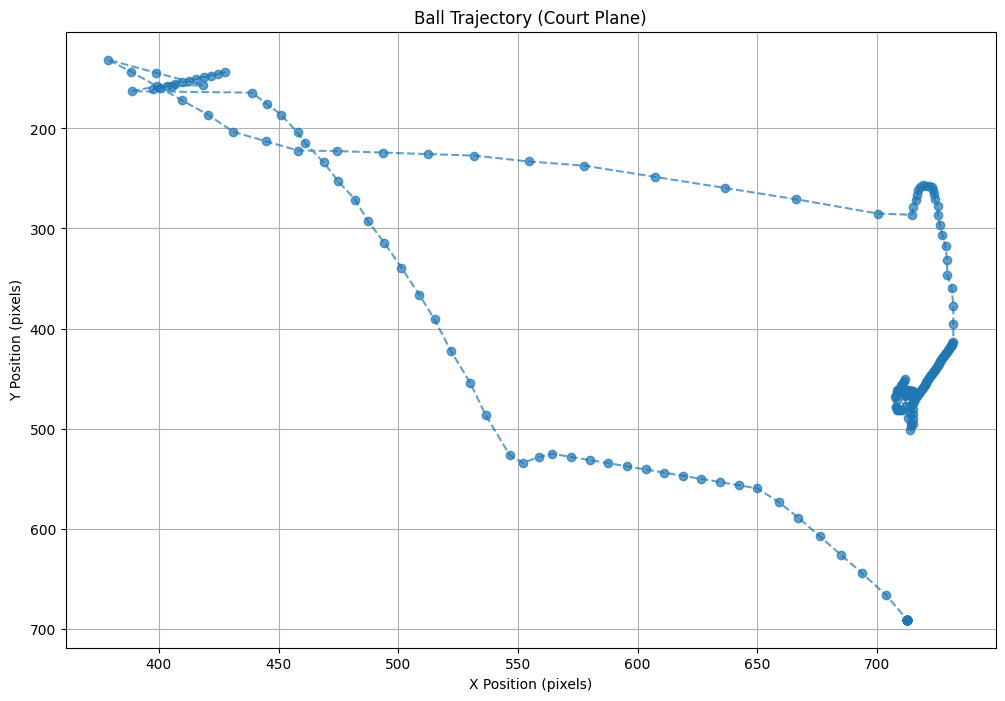

In [19]:
plot_trajectory(ball_detections)

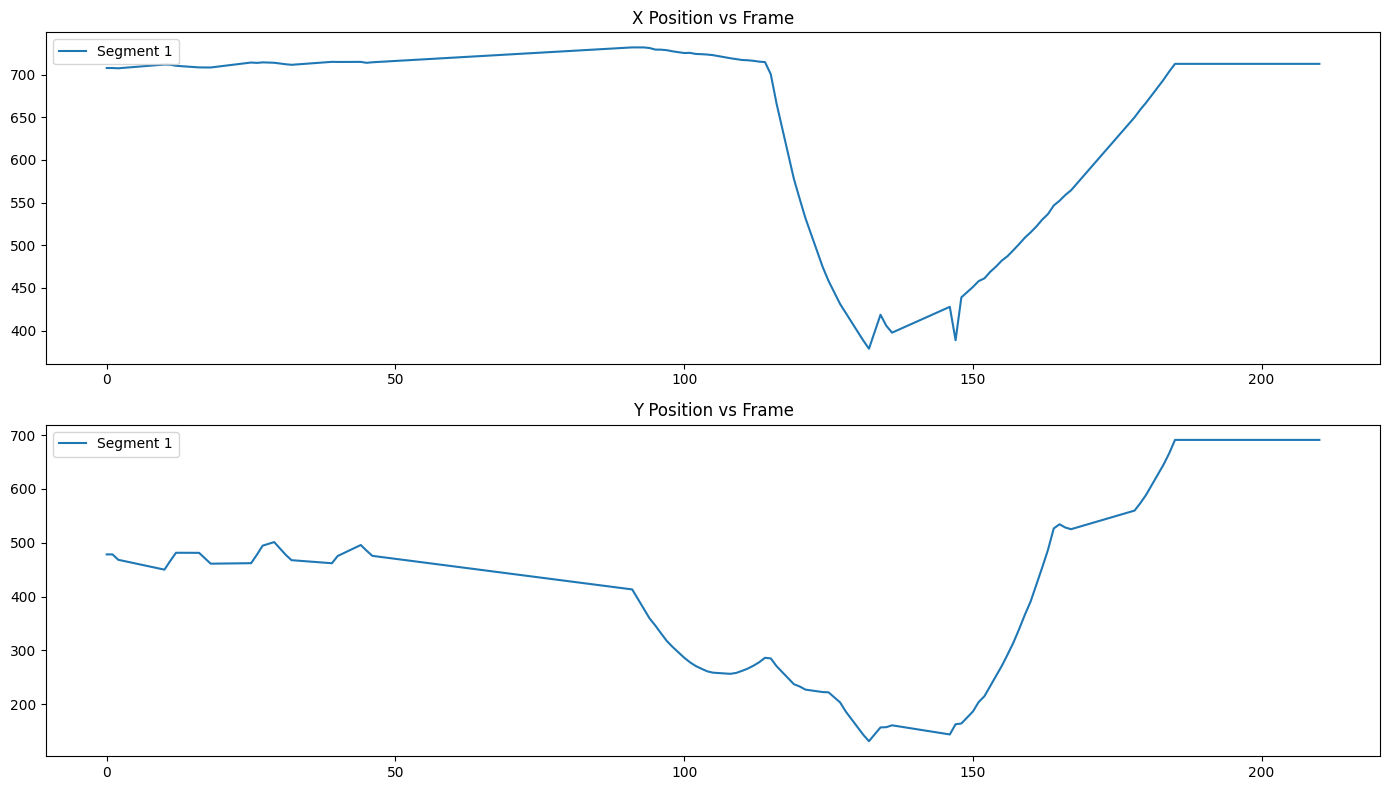

In [15]:
plot_position_over_time(ball_detections)

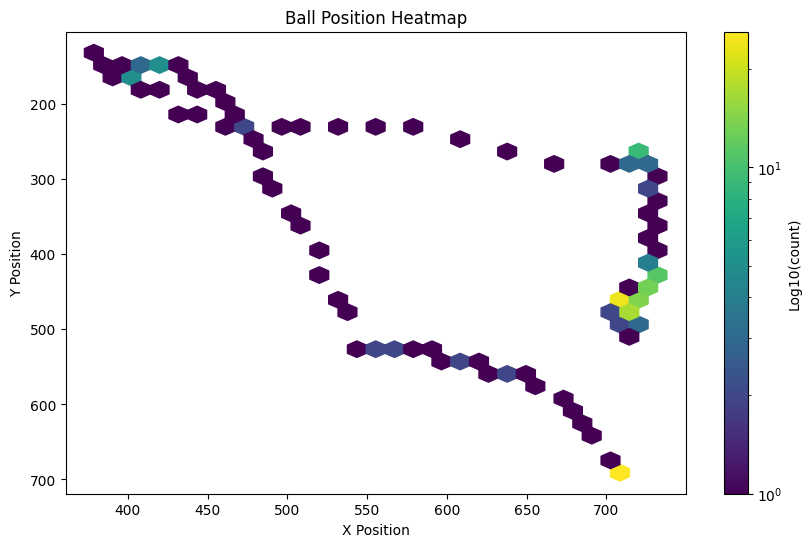

In [16]:
plot_heatmap(ball_detections)